In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# fix random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model specification

## Data

In [38]:
batch_size = 128
lr = 3e-4
log_interval = 10
num_epochs = 30

In [39]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("data", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [40]:
indexes = dict()
for index, target in enumerate(dataset1.targets.tolist()):
    if target not in indexes:
        indexes[target] = [index]
    else:
        indexes[target].append(index)

In [41]:
subsampled_indexes = dict()
for i in range(10):
    subsampled_indexes[i] = []
subsampled_data = []
subsampled_target = []
for key, sub_indexes in indexes.items():
    np_sub_indexes = np.random.choice(sub_indexes, 50, replace=False)
    subsampled_indexes[key] = np_sub_indexes
    for index in np_sub_indexes:
        data, target = dataset1.__getitem__(index)
        subsampled_data.append(torch.flatten(data))
        subsampled_target.append(target)
    

subsampled_data = torch.stack(subsampled_data)
subsampled_target = torch.tensor(subsampled_target)
subsampled_data.shape, subsampled_target.shape

(torch.Size([500, 784]), torch.Size([500]))

## Basic optimization loop

In the model definitions below, we assume that the bottleneck layer belongs to both the encoder and the decoder. A sigmoid activation is placed after the final layer to squish the output values back to the interval ``[0,1]`` since the input consists of grayscale images.

In [42]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [44]:
def train(dataloader, model, criterion, optimizer, num_epochs):
    losses = []
    model.train()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for x, _ in dataloader:
            x = x.view(-1, 28*28).to(device)
            x_hat = model(x)

            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss = running_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        losses.append(loss)
    
    return losses

In [45]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(train_loader, model, criterion, optimizer, num_epochs)

  3%|▎         | 1/30 [00:19<09:19, 19.31s/it]

Epoch 1/30, Loss: 0.990283


  7%|▋         | 2/30 [00:42<10:00, 21.43s/it]

Epoch 2/30, Loss: 0.800394


 10%|█         | 3/30 [01:02<09:21, 20.80s/it]

Epoch 3/30, Loss: 0.783883


 13%|█▎        | 4/30 [01:19<08:21, 19.28s/it]

Epoch 4/30, Loss: 0.779292


 17%|█▋        | 5/30 [01:38<08:04, 19.37s/it]

Epoch 5/30, Loss: 0.776062


 20%|██        | 6/30 [01:57<07:35, 18.99s/it]

Epoch 6/30, Loss: 0.773483


 23%|██▎       | 7/30 [02:13<07:00, 18.30s/it]

Epoch 7/30, Loss: 0.771556


 27%|██▋       | 8/30 [02:33<06:48, 18.58s/it]

Epoch 8/30, Loss: 0.766426


 30%|███       | 9/30 [02:51<06:30, 18.59s/it]

Epoch 9/30, Loss: 0.758022


 33%|███▎      | 10/30 [03:09<06:07, 18.36s/it]

Epoch 10/30, Loss: 0.751811


 37%|███▋      | 11/30 [03:28<05:49, 18.40s/it]

Epoch 11/30, Loss: 0.745803


 40%|████      | 12/30 [03:45<05:23, 17.99s/it]

Epoch 12/30, Loss: 0.741440


 43%|████▎     | 13/30 [04:02<05:05, 17.96s/it]

Epoch 13/30, Loss: 0.736979


 47%|████▋     | 14/30 [04:19<04:39, 17.49s/it]

Epoch 14/30, Loss: 0.732797


 50%|█████     | 15/30 [04:35<04:17, 17.19s/it]

Epoch 15/30, Loss: 0.730238


 53%|█████▎    | 16/30 [04:53<04:03, 17.37s/it]

Epoch 16/30, Loss: 0.727984


 57%|█████▋    | 17/30 [05:21<04:24, 20.37s/it]

Epoch 17/30, Loss: 0.726337


 60%|██████    | 18/30 [05:38<03:55, 19.62s/it]

Epoch 18/30, Loss: 0.724388


 63%|██████▎   | 19/30 [05:55<03:26, 18.76s/it]

Epoch 19/30, Loss: 0.723026


 67%|██████▋   | 20/30 [06:11<02:58, 17.87s/it]

Epoch 20/30, Loss: 0.721703


 70%|███████   | 21/30 [06:27<02:36, 17.37s/it]

Epoch 21/30, Loss: 0.720354


 73%|███████▎  | 22/30 [06:43<02:16, 17.02s/it]

Epoch 22/30, Loss: 0.718860


 77%|███████▋  | 23/30 [07:00<01:57, 16.82s/it]

Epoch 23/30, Loss: 0.717801


 80%|████████  | 24/30 [07:16<01:39, 16.66s/it]

Epoch 24/30, Loss: 0.716828


 83%|████████▎ | 25/30 [07:34<01:24, 16.95s/it]

Epoch 25/30, Loss: 0.715922


 87%|████████▋ | 26/30 [07:50<01:06, 16.71s/it]

Epoch 26/30, Loss: 0.715057


 90%|█████████ | 27/30 [08:06<00:49, 16.54s/it]

Epoch 27/30, Loss: 0.714149


 93%|█████████▎| 28/30 [08:22<00:32, 16.32s/it]

Epoch 28/30, Loss: 0.713308


 97%|█████████▋| 29/30 [08:38<00:16, 16.24s/it]

Epoch 29/30, Loss: 0.712564


100%|██████████| 30/30 [08:54<00:00, 17.82s/it]

Epoch 30/30, Loss: 0.711950


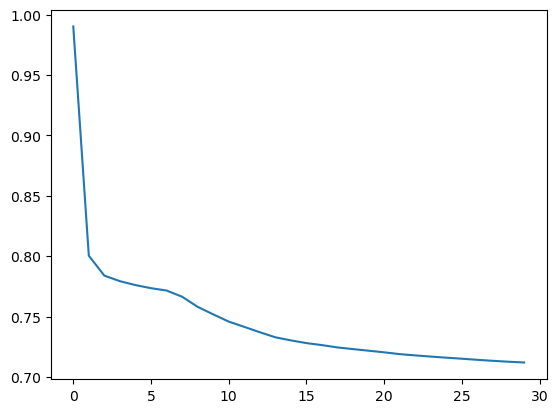

In [46]:
plt.plot(losses)
plt.show()

In [47]:
model.eval()
with torch.no_grad():
    embeddings1 = model.encoder(subsampled_data.to(device)).cpu().detach().numpy()

In [48]:
model = DeepAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(train_loader, model, criterion, optimizer, num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:18<08:51, 18.31s/it]

Epoch 1/30, Loss: 0.985205


  7%|▋         | 2/30 [00:36<08:38, 18.52s/it]

Epoch 2/30, Loss: 0.811451


 10%|█         | 3/30 [00:55<08:18, 18.45s/it]

Epoch 3/30, Loss: 0.797415


 13%|█▎        | 4/30 [01:13<07:54, 18.25s/it]

Epoch 4/30, Loss: 0.781812


 17%|█▋        | 5/30 [01:39<08:45, 21.02s/it]

Epoch 5/30, Loss: 0.767788


 20%|██        | 6/30 [02:04<08:55, 22.30s/it]

Epoch 6/30, Loss: 0.761780


 23%|██▎       | 7/30 [02:27<08:43, 22.75s/it]

Epoch 7/30, Loss: 0.758951


 27%|██▋       | 8/30 [02:50<08:23, 22.90s/it]

Epoch 8/30, Loss: 0.756234


 30%|███       | 9/30 [03:13<08:01, 22.93s/it]

Epoch 9/30, Loss: 0.753852


 33%|███▎      | 10/30 [03:36<07:35, 22.76s/it]

Epoch 10/30, Loss: 0.751228


 37%|███▋      | 11/30 [04:00<07:21, 23.25s/it]

Epoch 11/30, Loss: 0.749048


 40%|████      | 12/30 [04:21<06:47, 22.64s/it]

Epoch 12/30, Loss: 0.745303


 43%|████▎     | 13/30 [04:44<06:22, 22.52s/it]

Epoch 13/30, Loss: 0.740459


 47%|████▋     | 14/30 [05:08<06:07, 22.96s/it]

Epoch 14/30, Loss: 0.736835


 50%|█████     | 15/30 [05:30<05:42, 22.85s/it]

Epoch 15/30, Loss: 0.732438


 53%|█████▎    | 16/30 [05:55<05:27, 23.38s/it]

Epoch 16/30, Loss: 0.726929


 57%|█████▋    | 17/30 [06:12<04:39, 21.50s/it]

Epoch 17/30, Loss: 0.724050


 60%|██████    | 18/30 [06:29<04:01, 20.11s/it]

Epoch 18/30, Loss: 0.721682


 63%|██████▎   | 19/30 [06:50<03:44, 20.37s/it]

Epoch 19/30, Loss: 0.719545


 67%|██████▋   | 20/30 [07:17<03:43, 22.30s/it]

Epoch 20/30, Loss: 0.718037


 70%|███████   | 21/30 [07:42<03:29, 23.30s/it]

Epoch 21/30, Loss: 0.716790


 73%|███████▎  | 22/30 [08:02<02:57, 22.19s/it]

Epoch 22/30, Loss: 0.715645


 77%|███████▋  | 23/30 [08:23<02:32, 21.79s/it]

Epoch 23/30, Loss: 0.714634


 80%|████████  | 24/30 [08:46<02:14, 22.34s/it]

Epoch 24/30, Loss: 0.713595


 83%|████████▎ | 25/30 [09:09<01:52, 22.57s/it]

Epoch 25/30, Loss: 0.712720


 87%|████████▋ | 26/30 [09:33<01:30, 22.75s/it]

Epoch 26/30, Loss: 0.712041


 90%|█████████ | 27/30 [09:57<01:09, 23.17s/it]

Epoch 27/30, Loss: 0.711361


 93%|█████████▎| 28/30 [10:24<00:48, 24.32s/it]

Epoch 28/30, Loss: 0.710718


 97%|█████████▋| 29/30 [10:43<00:22, 22.70s/it]

Epoch 29/30, Loss: 0.710193


100%|██████████| 30/30 [11:07<00:00, 22.24s/it]

Epoch 30/30, Loss: 0.709702


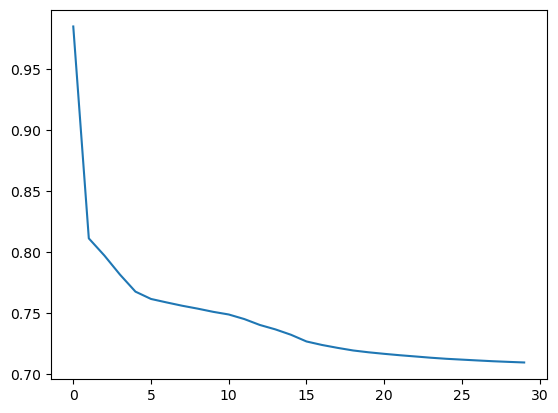

In [49]:
plt.plot(losses)
plt.show()

In [50]:
model.eval()
with torch.no_grad():
    embeddings2 = model.encoder(subsampled_data.to(device)).cpu().detach().numpy()

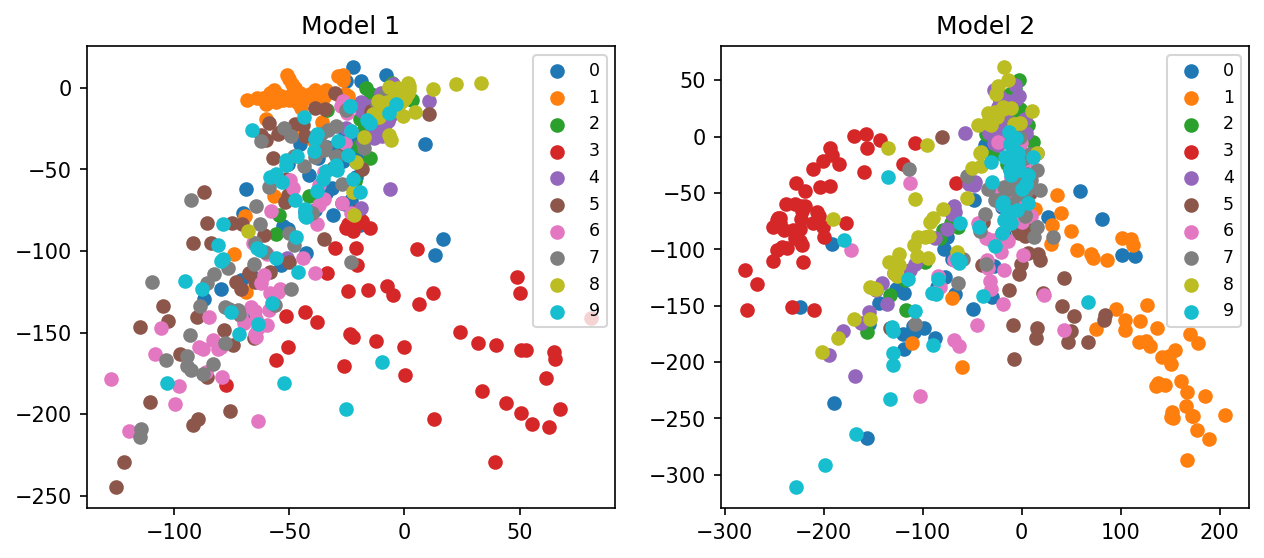

In [51]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
cmap = plt.get_cmap("tab10")
axs[0].set_title("Model 1")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[0].scatter(embeddings1[50*i: 50*(i+1), 0], embeddings1[50*i: 50*(i+1), 1], color=color, label=key)
axs[0].legend(fontsize="small")
axs[1].set_title("Model 2")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[1].scatter(embeddings2[50*i: 50*(i+1), 0], embeddings2[50*i: 50*(i+1), 1], color=color, label=key)
axs[1].legend(fontsize="small")
plt.show()